In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']

import numpy as np
import scipy
from scipy import misc as scmisc
import scipy.special as ss
import scipy.linalg as sl
import scipy.integrate as si
import scipy.interpolate as interp
import scipy.constants as sc
import scipy.optimize as sopt
import scipy.stats as scistats
import sys,os

In [2]:
# importing parallel-tempering MCMC sampler.

import PTMCMCSampler 

In [3]:
from PTMCMCSampler import PTMCMCSampler as ptmcmc

In [4]:
# create some data as draws from a funky distribution.

test_weird = np.concatenate((np.random.normal(2.0,1.0,2e3),np.random.normal(7.5,0.5,1.5e3),np.random.normal(10.0,1.0,1e3),np.random.rayleigh(4.0,1e3)+10.))

/Users/staylor/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


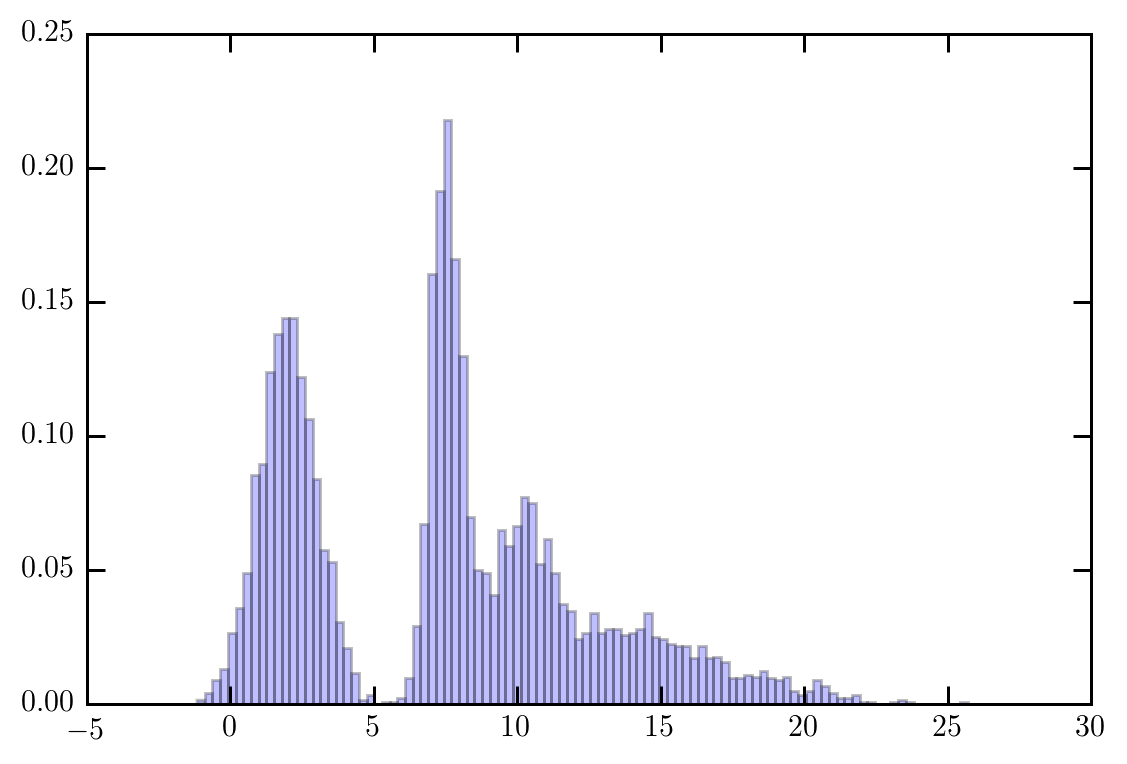

In [11]:
n, bins, patches = plt.hist(test_weird, 100, normed=1, facecolor='blue', alpha=0.25)

In [5]:
import sklearn
from sklearn import mixture as mix

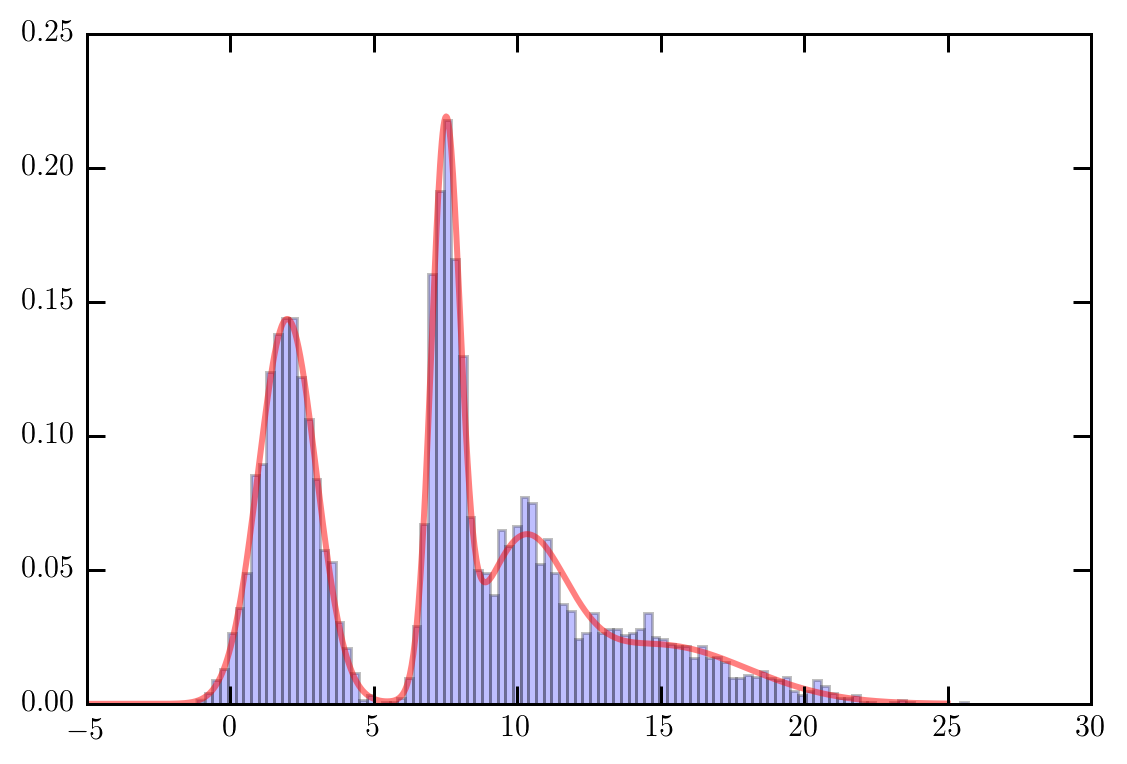

In [49]:
# let's just use the expectation-maximisation gmm fitting from sklearn

clf = mix.GMM(n_components=4, covariance_type='diag')
clf.fit(test_weird.reshape((len(test_weird),1)))

#clf.means_ = np.linspace(1.,5.,4).reshape((4,1))

x = np.linspace(-5.0, 25.0, 1000)
z = clf.score(x.reshape((len(x),1))) 

n, bins, patches = plt.hist(test_weird, 100, normed=1, facecolor='blue', alpha=0.25)
plt.plot(x,np.exp(z),color='red',lw=2.0,alpha=0.5)

In [50]:
print clf.means_.shape, 
print '\n\n', clf.covars_.shape, 
print '\n\n', clf.weights_

(4, 1) 

(4, 1) 

[ 0.20776188  0.3633903   0.25978387  0.16906395]


In [15]:
# How many mixture components do we need? 
# Let's look at the AIC and BIC.

n = np.arange(1, 11)
models = [None for i in range(len(n))]

for ii in range(len(n)):
    models[ii] = mix.GMM(n[ii]).fit(test_weird.reshape((len(test_weird),1)))

# compute the AIC and the BIC
AIC = [mm.aic(test_weird.reshape((len(test_weird),1))) for mm in models]
BIC = [mm.bic(test_weird.reshape((len(test_weird),1))) for mm in models]

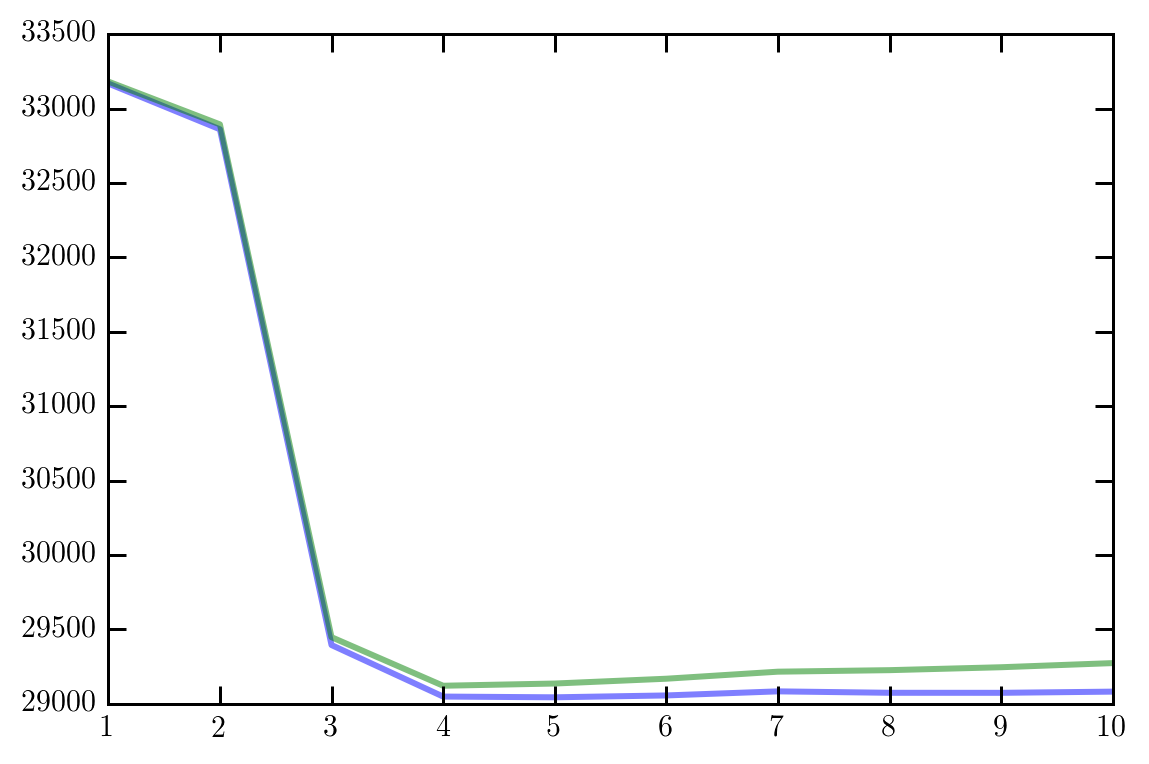

In [16]:
plt.plot(n, AIC, color='blue', lw=2.0, alpha=0.5)
plt.plot(n, BIC, color='green', lw=2.0, alpha=0.5)

In [54]:
ngmm = np.rint(5.2)
gmm = mix.GMM(ngmm,covariance_type='diag')

In [75]:
# INSTEAD, let's just sample the optimal number of mixture components (Hee et al. (2015)),
# the means and covariances of the components.

pmin = np.concatenate(([1.0],-5.*np.ones(10),-2.*np.ones(10))) #first parameter is now the number of shapelets
pmax = np.concatenate(([10.0],25.*np.ones(10),1.*np.ones(10))) #first parameter is now the number of shapelets

def my_prior(x):
    logp = 0.
    
    if np.all(x <= pmax) and np.all(x >= pmin):
        logp = np.sum(np.log(1/(pmax-pmin)))
    else:
        logp = -np.inf
    
    return logp

def lnprob(xx):
    
    ngmm = np.rint(xx[0])
    gmm = mix.GMM(ngmm,covariance_type='diag')
    
    gmm.means_ = xx[1:ngmm+1].reshape((ngmm,1))
    gmm.covars_ = (10.**xx[11:11+ngmm]).reshape((ngmm,1))
    
    return np.sum(gmm.score(test_weird.reshape((len(test_weird),1))))

In [76]:
sampler = ptmcmc.PTSampler(ndim=21,logl=lnprob,logp=my_prior,cov=np.diag(0.5*np.ones(21)),
                                      outDir='./chain_gmm',resume=False)

In [77]:
sampler.sample(p0=np.concatenate(([5.0],3.0*np.ones(10),0.1*np.ones(10))),Niter=1e5,thin=10)

Finished 10.00 percent in 7.888915 s Acceptance rate = 0.1181Adding DE jump with weight 20
Finished 99.00 percent in 86.143276 s Acceptance rate = 0.18397
Run Complete


/Users/staylor/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/staylor/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [78]:
chain_gmm = np.loadtxt('./chain_gmm/chain_1.txt')

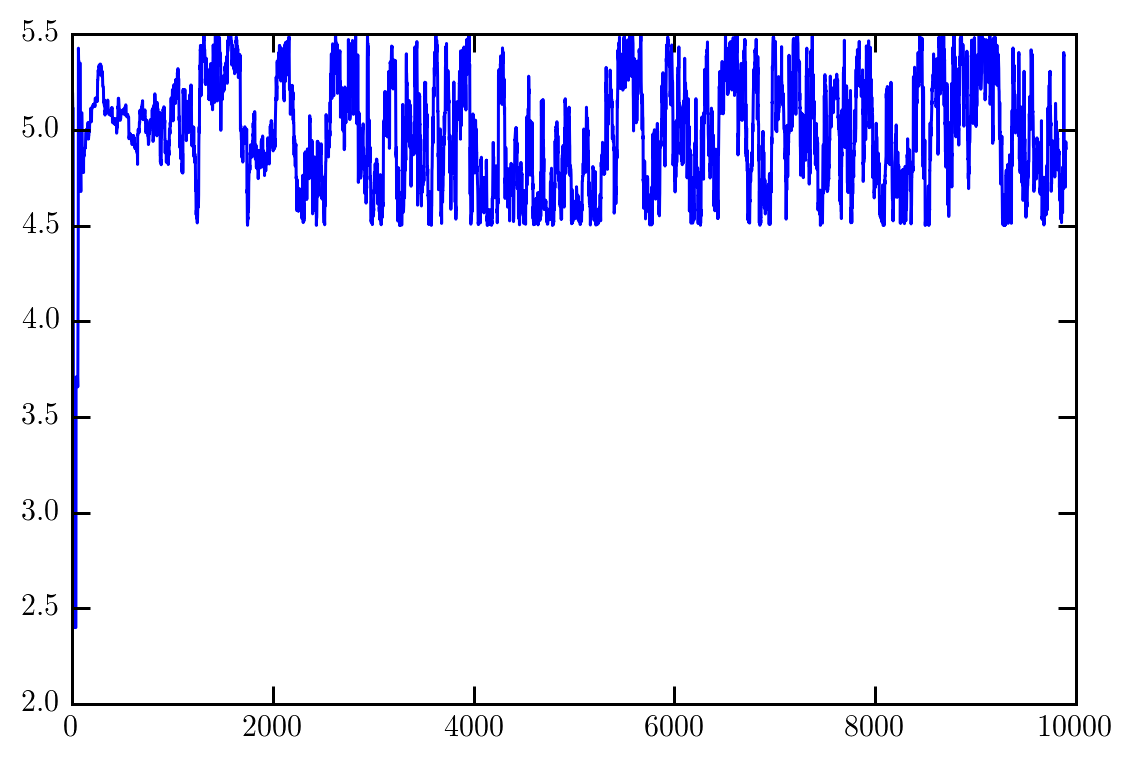

In [79]:
plt.plot(chain_gmm[:,0])

/Users/staylor/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/staylor/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


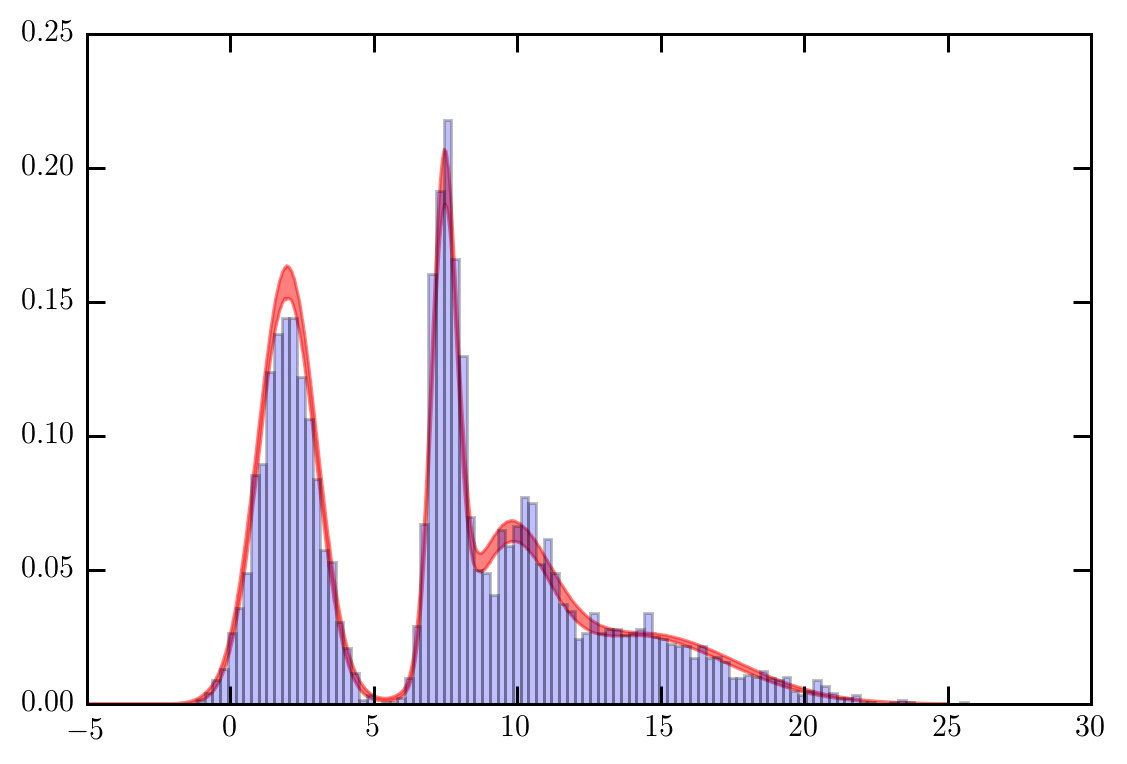

In [88]:
# Let's plot the posterior solution envelope from the chain.

def getclr(dat, nedges, cfvalue):
    "get the bound"
    counts,edges=np.histogram(dat, nedges)
    counts=np.float64(np.array(counts))/len(dat)
    ind_center=np.argmax(counts)
    maxc=counts[ind_center]
    cedges=(edges[0:-1]+edges[1:])*0.5
    sort_ind=np.argsort(-counts)
    cflevel=np.cumsum(counts[sort_ind])
    ind_cflevel=cflevel<=cfvalue
    conf_data=cedges[sort_ind][ind_cflevel]
    left=np.min(conf_data)
    right=np.max(conf_data)
    return cedges[ind_center], left, right

vcoef=chain_gmm[2000:,:21]
row,col=vcoef.shape
theta=np.linspace(-5.0,25.,1000)
hdf=np.zeros((row, len(theta)))
x=np.array([])
y=np.array([])
for ii in range(row):
    ngmm = np.rint(vcoef[ii,0])
    gmm.means_ = vcoef[ii,1:ngmm+1].reshape((ngmm,1))
    gmm.covars_ = (10.**vcoef[ii,11:11+ngmm]).reshape((ngmm,1))
    vh = np.exp(gmm.score(theta.reshape((len(theta),1))))
    #print dist, norm, np.any(np.isnan(vh))
    hdf[ii,:]=vh

#combine all the distribution of lines
x=np.tile(theta,row)
y=hdf.reshape((len(x),))

# get the central and bound of the lines
hdf_c=np.zeros(len(theta))
hdf_l=np.zeros(len(theta))
hdf_r=np.zeros(len(theta))
row,col=hdf.shape

for ii in range(col):
    dat=hdf[:,ii]
    if dat.shape[0]==0:
        print 'ok'
    c,l,r=getclr(dat,60, 0.95)
    hdf_c[ii]=np.mean(dat)
    hdf_l[ii]=l
    hdf_r[ii]=r

fig,ax = plt.subplots()
plt.fill_between(theta, hdf_l, hdf_r, color='red', alpha=0.5)
n, bins, patches = plt.hist(test_weird, 100, normed=1, facecolor='blue', alpha=0.25)

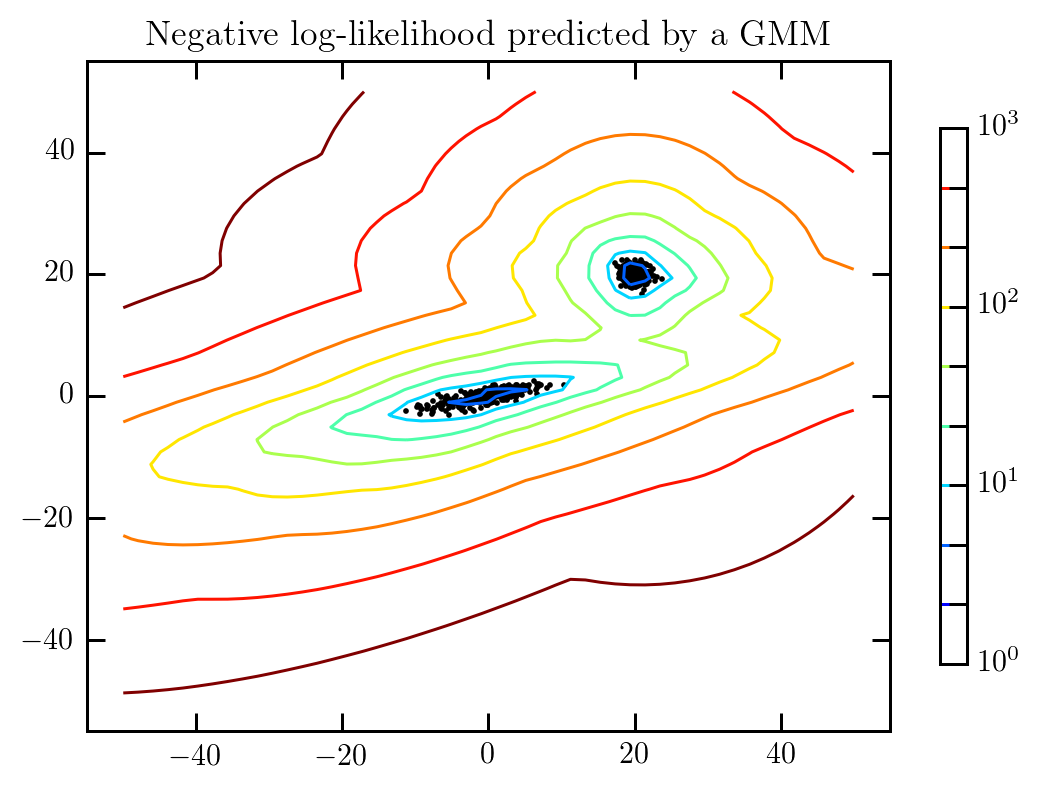

In [6]:
# Below are just some 2D tests taken from online examples.

from matplotlib.colors import LogNorm

n_samples = 300

# generate random sample, two components
#np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mix.GMM(n_components=20, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-50.0, 50.0)
y = np.linspace(-50.0, 50.0)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)[0]
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

In [7]:
n = np.arange(1, 11)
models = [None for i in range(len(n))]

for ii in range(len(n)):
    models[ii] = mix.GMM(n_components=n[ii], covariance_type='full').fit(X_train)

# compute the AIC and the BIC
AIC = [mm.aic(X_train) for mm in models]
BIC = [mm.bic(X_train) for mm in models]

## Extreme deconvolution tests

In [6]:
# create some data as draws from a funky distribution.

mass_true = np.concatenate((np.random.normal(2.0,1.0,int(1e4)),np.random.normal(7.5,0.5,int(5e4)),np.random.normal(10.0,1.0,int(2e4)),np.random.rayleigh(4.0,int(2e4))+10.))

In [7]:
# The true property for each system
systems = np.concatenate((np.random.normal(2.0,1.0,100),np.random.normal(7.5,0.5,500),np.random.normal(10.0,1.0,200),np.random.rayleigh(4.0,200)+10.))

In [8]:
# The MCMC samples for each system detection
systems_samp = np.array([np.random.normal(sys,0.01*np.abs(sys),1000) for sys in systems])

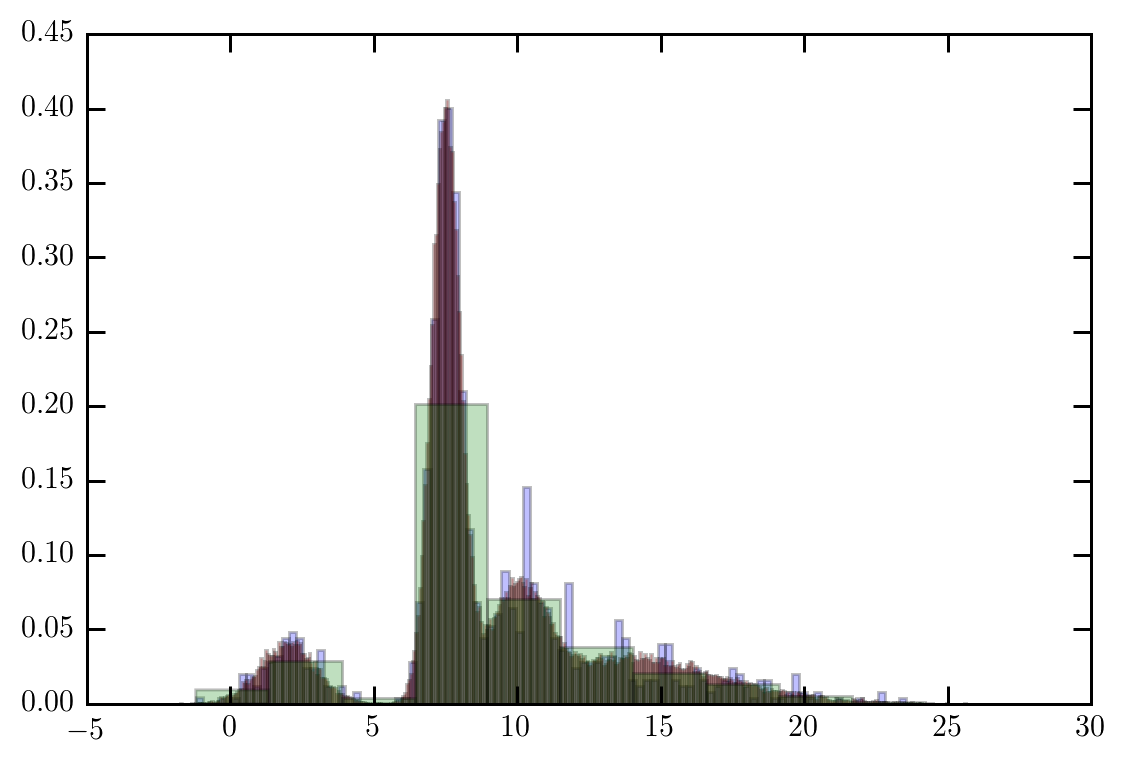

In [9]:
n, bins, patches = plt.hist(systems, 100, normed=1, facecolor='blue', alpha=0.25)
n, bins, patches = plt.hist(mass_true, 500, normed=1, facecolor='red', alpha=0.25)
n, bins, patches = plt.hist(systems_samp[:,::10].flatten(), 10, normed=1, facecolor='green', alpha=0.25)

In [22]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from astroML.decorators import pickle_results
from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------

In [60]:
# add scatter to "true" distribution
dx = 0.2*np.abs(systems)

x_true = systems.copy()
x_true += np.random.normal(0, dx, len(systems))

# add noise to get the "observed" distribution
#dx = 0.2 + 0.01 * systems * np.random.random(len(systems))

x = x_true + np.random.normal(0, dx)

# stack the results for computation
X = np.vstack([x]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([dx ** 2]).T

In [61]:
#------------------------------------------------------------
# compute and save results
#@pickle_results("XD_toy.pkl")
def compute_XD_results(n_components=10, n_iter=500):
    clf = XDGMM(n_components, n_iter=n_iter)
    clf.fit(X, Xerr)
    return clf

In [ ]:
clf = compute_XD_results(20)
sample = clf.sample(10000)

clfnew = mix.GMM(n_components=20, covariance_type='diag')
clfnew.fit(x.reshape((len(x),1)))
samplenew = clfnew.sample(10000)

In [ ]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(221)
n, bins, patches = plt.hist(mass_true, 100, normed=1, facecolor='blue', alpha=0.25)

ax2 = fig.add_subplot(222)
n, bins, patches = plt.hist(x, 50, normed=1, facecolor='red', alpha=0.25)

ax3 = fig.add_subplot(223)
n, bins, patches = plt.hist(sample[:,0], 100, normed=1, facecolor='green', alpha=0.25)

ax4 = fig.add_subplot(224)
n, bins, patches = plt.hist(samplenew[:,0], 100, normed=1, facecolor='cyan', alpha=0.25)

titles = ["True Distribution", "Noisy Samples $(N=1000)$",
          "Extreme Deconvolution\n  resampling",
          "Deconvolution\n  resampling"]

ax = [ax1, ax2, ax3, ax4]

for ii in range(4):
    ax[ii].set_xlim(-4, 28)
    #ax[i].set_ylim(-6, 16)

    ax[ii].xaxis.set_major_locator(plt.MultipleLocator(4))
    ax[ii].yaxis.set_major_locator(plt.MultipleLocator(5))

    ax[ii].text(0.05, 0.95, titles[ii],
               ha='left', va='top', transform=ax[ii].transAxes)

    if ii in (0, 1):
        ax[ii].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[ii].set_xlabel('$x$')

    if ii in (1, 3):
        ax[ii].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[ii].set_ylabel('$y$')